# ***CONVOLUTIONAL NEURAL NETWORK***

**Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Library**

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

**Tampilkan grafik Citra Kolong**

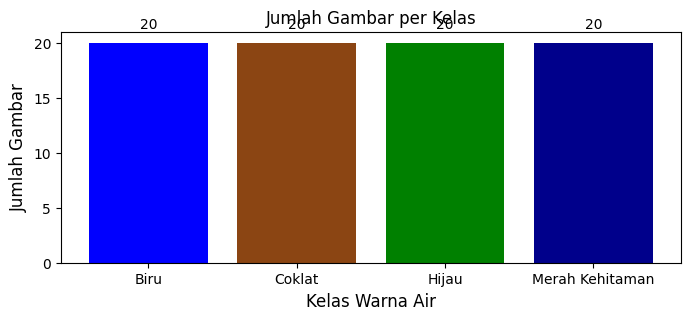

In [ ]:
# --- 1. Load path gambar per kelas ---
biru_images   = glob.glob("/content/drive/MyDrive/Kolong/Bahan_ver2/Biru/*.png")
coklat_images = glob.glob("/content/drive/MyDrive/Kolong/Bahan_ver2/Coklat/*.png")
hijau_images  = glob.glob("/content/drive/MyDrive/Kolong/Bahan_ver2/Hijau/*.png")
meta_images   = glob.glob("/content/drive/MyDrive/Kolong/Bahan_ver2/Merah Kehitaman/*.png")

jumlah_gambar = {
    "Biru" : len(biru_images),
    "Coklat" : len(coklat_images),
    "Hijau" : len(hijau_images),
    "Merah Kehitaman" : len(meta_images)
}

# --- Plot grafik ---
plt.figure(figsize=(8,3))
bars = plt.bar(jumlah_gambar.keys(), jumlah_gambar.values(), color=['blue', 'saddlebrown', 'green', 'darkblue'])

# Tambahkan angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.title("Jumlah Gambar per Kelas", fontsize=12)
plt.xlabel("Kelas Warna Air", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.show()

**Labeling**

In [ ]:
biru_labels   = [0] * len(biru_images)
coklat_labels = [1] * len(coklat_images)
hijau_labels  = [2] * len(hijau_images)
meta_labels   = [3] * len(meta_images)

data   = biru_images + coklat_images + hijau_images + meta_images
labels = biru_labels + coklat_labels + hijau_labels + meta_labels
labels = np.array(labels)

print(f"Total data: {len(data)}")
print(f"Total labels: {len(labels)}")

Total data: 80
Total labels: 80


**Ekstraksi RGB**

In [ ]:
# --- 4. Ekstraksi citra (X1) untuk CNN ---
X1 = []
for img_path in data:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256,256))  # ubah ukuran seragam
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X1.append(img)

X1 = np.array(X1, dtype="float32") / 255.0   # normalisasi 0–1

print(f"Shape X1 (CNN): {X1.shape}")

Shape X1 (CNN): (80, 256, 256, 3)


In [ ]:
# tampilkan 5 baris pertama# --- 5. Ekstraksi ciri RGB (X2) ---
def extract_rgb_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # rata-rata tiap channel
    r_mean = np.mean(img[:,:,0])
    g_mean = np.mean(img[:,:,1])
    b_mean = np.mean(img[:,:,2])

    # normalisasi proporsional
    total = r_mean + g_mean + b_mean
    if total == 0:
        r_norm, g_norm, b_norm = 0, 0, 0
    else:
        r_norm = r_mean / total
        g_norm = g_mean / total
        b_norm = b_mean / total

    return [r_norm, g_norm, b_norm]

X2 = []
for img_path in data:
    X2.append(extract_rgb_features(img_path))

X2 = np.array(X2, dtype="float32")

print(f"Shape X2 (RGB features): {X2.shape}")

Shape X2 (RGB features): (80, 3)


# **Jika menggunakan K-Fold Cross Validation lewati pembagian data samapai akurasi model**

**Pembagian Data**

In [ ]:
from sklearn.model_selection import train_test_split

# --- 6. Split data train/test ---
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, labels, test_size=0.2, random_state=42, stratify=labels
)

# **Menampilkan pembagian data X2**

In [ ]:
# Buat DataFrame train
train_df = pd.DataFrame(X2_train, columns=['R_mean', 'G_mean', 'B_mean'])
train_df['label'] = y_train
train_df['split'] = 'train'

# Buat DataFrame test
test_df = pd.DataFrame(X2_test, columns=['R_mean', 'G_mean', 'B_mean'])
test_df['label'] = y_test
test_df['split'] = 'test'

# Gabungkan
all_df = pd.concat([train_df, test_df], ignore_index=True)

# Simpan ke CSV
all_df.to_csv("X2_split.csv", index=False)

print("Data gabungan X2 (train/test) disimpan sebagai X2_split.csv")
print(all_df.head())

Data gabungan X2 (train/test) disimpan sebagai X2_split.csv
     R_mean    G_mean    B_mean  label  split
0  0.070038  0.414265  0.515697      0  train
1  0.367705  0.329767  0.302528      1  train
2  0.303499  0.337370  0.359131      1  train
3  0.328429  0.343876  0.327696      1  train
4  0.242209  0.466987  0.290803      2  train


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Data augmentation (rotasi, zoom, flip, dll.)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Latih generator hanya pada data training
datagen.fit(X1_train)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Hitung class weight agar kelas seimbang
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test  = to_categorical(y_test, num_classes=4)
print(y_train.shape, y_test.shape)


(64, 4) (16, 4)


**Model**

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# --- 1. Input Branch 1 (CNN untuk citra) ---
input_cnn = Input(shape=(256,256,3))
x = Conv2D(32, (3,3), activation='relu')(input_cnn)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(256, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)

# --- 2. Input Branch 2 (fitur RGB) ---
input_rgb = Input(shape=(3,))
y = Dense(64, activation='relu')(input_rgb)

# --- 3. Gabungkan keduanya ---
combined = Concatenate()([x, y])
z = Dense(256, activation='relu')(combined)
z = Dropout(0.3)(z)

output = Dense(4, activation='softmax')(z)   # 4 kelas: Biru, Coklat, Hijau, Merah Kehitaman

In [ ]:
from tensorflow.keras.models import Model

# --- 4. Definisikan model ---
model = Model(inputs=[input_cnn, input_rgb], outputs=output)

In [ ]:
# --- 5. Compile model ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 62, 62,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 60,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 30,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ max_pooling2d_3[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     82,176 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 537,668 (2.05 MB)

 Trainable params: 537,668 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

**Training Model**

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 20))
history = model.fit([X1_train, X2_train], y_train,
                    validation_data=([X1_test, X2_test], y_test),
                    epochs=30,
                    verbose=1,
                    class_weight=class_weights,
                    callbacks=[lr_schedule]
                    )

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.1771 - loss: 1.3973 - val_accuracy: 0.2500 - val_loss: 1.3713 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.2708 - loss: 1.3659 - val_accuracy: 0.3125 - val_loss: 1.3628 - learning_rate: 8.9125e-04
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.3542 - loss: 1.3373 - val_accuracy: 0.3125 - val_loss: 1.3474 - learning_rate: 7.9433e-04
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.3958 - loss: 1.3155 - val_accuracy: 0.3125 - val_loss: 1.3291 - learning_rate: 7.0795e-04
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.4271 - loss: 1.2856 - val_accuracy: 0.3125 - val_loss: 1.2869 - learning_rate: 6.3096e-04
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.4479 - loss: 1.2367 - val_accuracy: 0.3750 - val_loss: 1.2450 - learning_rate: 5.6234e-04
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.4375 - loss: 1.2121 - val_accu

**Akurasi Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
                 precision    recall  f1-score   support

           Biru       1.00      1.00      1.00         4
         Coklat       0.67      0.50      0.57         4
          Hijau       0.60      0.75      0.67         4
Merah kehitaman       1.00      1.00      1.00         4

       accuracy                           0.81        16
      macro avg       0.82      0.81      0.81        16
   weighted avg       0.82      0.81      0.81        16



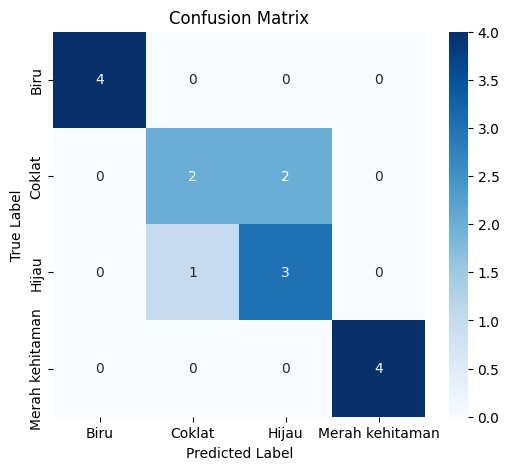

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns


# 1. Prediksi model
y_pred = model.predict([X1_test, X2_test])
y_pred_classes = np.argmax(y_pred, axis=1)   # ambil kelas dengan probabilitas tertinggi

# 2. Label asli
y_true = np.argmax(y_test, axis=1)

# 3. Classification report
target_names = ['Biru', 'Coklat', 'Hijau', 'Merah kehitaman']  # nama kelas Anda
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# 4. Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


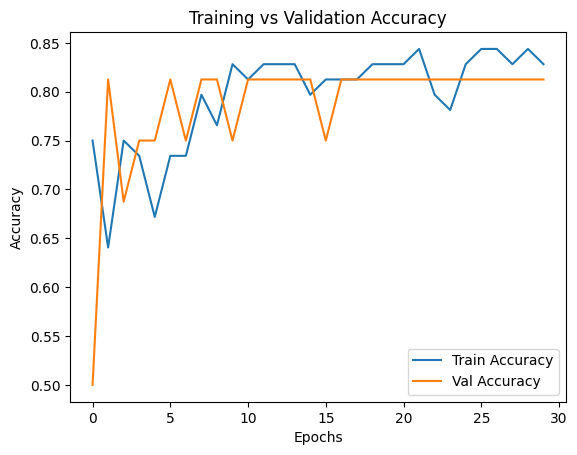

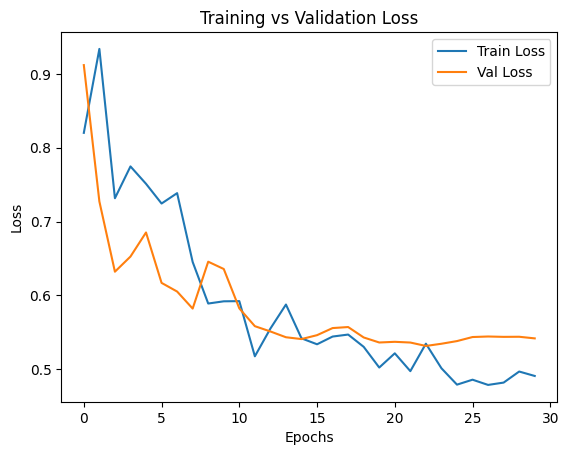

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# **Menggunakan K-Fold Cross Validation**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate,
                                     RandomFlip, RandomRotation, RandomZoom, RandomContrast)
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# One-hot encoding labels
y = to_categorical(labels, num_classes=4)

# Inisialisasi K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []

for train_index, val_index in kf.split(X1, y):
    print(f"\n=== Fold {fold_no} ===")

    # Split data untuk fold ini
    X1_train, X1_val = X1[train_index], X1[val_index]
    X2_train, X2_val = X2[train_index], X2[val_index]
    y_train, y_val   = y[train_index], y[val_index]

    # --- Definisi ulang model setiap fold ---
    # Branch CNN dengan augmentasi
    input_cnn = Input(shape=(256,256,3))
    aug = RandomFlip("horizontal_and_vertical")(input_cnn)
    aug = RandomRotation(0.1)(aug)
    aug = RandomZoom(0.1)(aug)
    aug = RandomContrast(0.1)(aug)

    # Definisi ulang model setiap fold
    input_cnn = Input(shape=(256,256,3))
    x = Conv2D(32, (3,3), activation='relu')(input_cnn)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(256, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    input_rgb = Input(shape=(3,))
    y_in = Dense(128, activation='relu')(input_rgb)

    combined = Concatenate()([x, y_in])
    z = Dense(64, activation='relu')(combined)
    output = Dense(4, activation='softmax')(z)

    model = Model(inputs=[input_cnn, input_rgb], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training
    history = model.fit([X1_train, X2_train], y_train,
                        validation_data=([X1_val, X2_val], y_val),
                        epochs=20,
                        batch_size=16,
                        verbose=1)

    # Evaluasi
    y_pred = model.predict([X1_val, X2_val])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Hitung akurasi
    acc = accuracy_score(y_true, y_pred_classes)
    print("Akurasi fold:", acc)
    print(classification_report(y_true, y_pred_classes, target_names=['Biru','Coklat','Hijau','Merah kehitaman']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Biru','Coklat','Hijau','Merah kehitaman'],
                yticklabels=['Biru','Coklat','Hijau','Merah kehitaman'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Fold {fold_no}")
    plt.show()

    acc_per_fold.append(acc)
    fold_no += 1

print("\n=== Rata-rata akurasi seluruh fold ===")
print(np.mean(acc_per_fold))


=== Fold 1 ===


NameError: name 'X2' is not defined

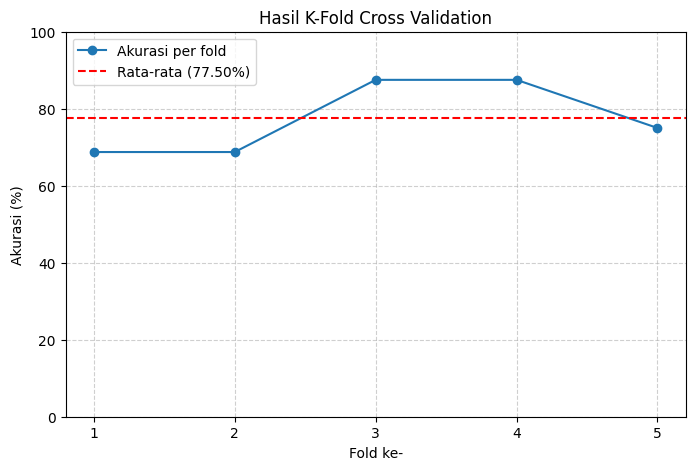

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data akurasi per fold (sudah ada dari K-Fold)
folds = range(1, len(acc_per_fold) + 1)
acc_values = [a * 100 for a in acc_per_fold]  # ubah ke persen
avg_acc = np.mean(acc_values)

# Plot
plt.figure(figsize=(8,5))
plt.plot(folds, acc_values, marker='o', linestyle='-', label='Akurasi per fold')
plt.axhline(y=avg_acc, color='r', linestyle='--', label=f'Rata-rata ({avg_acc:.2f}%)')

# Dekorasi grafik
plt.xticks(folds)
plt.ylim(0, 100)
plt.xlabel("Fold ke-")
plt.ylabel("Akurasi (%)")
plt.title("Hasil K-Fold Cross Validation")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Download Model**

In [ ]:
model.save("/content/drive/MyDrive/Kolong/CNN_81%.h5")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np # Import numpy
import cv2 # Import cv2

# Load the saved CNN model
loaded_cnn_model = load_model('/content/drive/MyDrive/Kolong/CNN_skripsi-fix.h5')

# Function to preprocess a single image for prediction
def preprocess_image_for_prediction(img_path):
    # Preprocess for CNN input
    img_cnn = image.load_img(img_path, target_size=(256, 256)) # Ensure target_size is (256, 256)
    img_array_cnn = image.img_to_array(img_cnn)
    img_array_cnn = np.expand_dims(img_array_cnn, axis=0) / 255.0  # Add batch dimension and normalize

    # Preprocess for RGB features input
    img_rgb = cv2.imread(img_path)
    img_rgb = cv2.resize(img_rgb, (256, 256))
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    r_mean = np.mean(img_rgb[:,:,0]) / 255.0
    g_mean = np.mean(img_rgb[:,:,1]) / 255.0
    b_mean = np.mean(img_rgb[:,:,2]) / 255.0
    rgb_features = np.array([[r_mean, g_mean, b_mean]], dtype="float32") # Add batch dimension

    return img_array_cnn, rgb_features


# Example prediction (replace with the path to your new image)
new_image_path = '/content/drive/MyDrive/Kolong/Bahan_ver2/Hijau/tambah23.png' # Replace with your image path
processed_image_cnn, processed_rgb_features = preprocess_image_for_prediction(new_image_path)


# Predict the class probabilities using both inputs
predictions = loaded_cnn_model.predict([processed_image_cnn, processed_rgb_features])

# Get the predicted class label (the one with the highest probability)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Define your class labels based on your training data order
class_labels = ['Biru', 'Coklat', 'Hijau', 'Merah Kehitaman'] # Adjust if your order is different

predicted_warna = class_labels[predicted_class_index]

print(f"Predicted color for the image: {predicted_warna}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
Predicted color for the image: Hijau


# **K-Nearest Neighbor**

**Data Kolong**

In [ ]:
# df = pd.read_csv('drug200.csv')
df = pd.read_csv('/content/drive/MyDrive/Kolong/Dataset_skripsi0.csv')
df

,Tempat,pH,DO,TDS,Warna,Umur_Kolong
0,Lokasi 26.png,5.00,7.16,52.00,Biru,20 - 25 tahun
1,Lokasi 35.png,5.00,5.80,34.00,Biru,20 - 25 tahun
2,Lokasi 47.png,5.00,6.98,36.00,Biru,20 - 25 tahun
3,Lokasi 57.png,3.60,45.00,0.87,Biru,20 - 25 tahun
4,Lokasi 63.png,7.10,7.80,0.88,Biru,20 - 25 tahun
...,...,...,...,...,...,...
75,tambah40.png,3.44,4.34,33.00,Merah Kehitaman,Lebih dari 50 tahun
76,tambah41.png,4.12,5.23,27.00,Merah Kehitaman,Lebih dari 50 tahun
77,tambah42.png,3.23,5.33,29.00,Merah Kehitaman,Lebih dari 50 tahun
78,tambah43.png,4.11,3.22,28.00,Merah Kehitaman,Lebih dari 50 tahun


**Filterisasi Data**

In [ ]:
df.isnull().sum() # melihat data kosong

,0
Tempat,0
pH,0
DO,0
TDS,0
Warna,0
Umur_Kolong,0


In [ ]:
df.duplicated().sum()   # duplikat data

np.int64(0)

In [ ]:
df.head()

,Tempat,pH,DO,TDS,Warna,Umur_Kolong
0,Lokasi 26.png,5.0,7.16,52.00,Biru,20 - 25 tahun
1,Lokasi 35.png,5.0,5.80,34.00,Biru,20 - 25 tahun
2,Lokasi 47.png,5.0,6.98,36.00,Biru,20 - 25 tahun
3,Lokasi 57.png,3.6,45.00,0.87,Biru,20 - 25 tahun
4,Lokasi 63.png,7.1,7.80,0.88,Biru,20 - 25 tahun


**Labeling**

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Tempat'] = label_encoder.fit_transform(df['Tempat'])
df['Warna'] = label_encoder.fit_transform(df['Warna'])
df['Umur_Kolong'] = label_encoder.fit_transform(df['Umur_Kolong'])

In [ ]:
df.head()

,Tempat,pH,DO,TDS,Warna,Umur_Kolong
0,8,5.0,7.16,52.00,0,0
1,13,5.0,5.80,34.00,0,0
2,18,5.0,6.98,36.00,0,0
3,23,3.6,45.00,0.87,0,0
4,28,7.1,7.80,0.88,0,0


In [ ]:
X_KNN = df.drop(columns = ['Warna'])
y_KNN = df['Warna']

print("X : ", X_KNN.shape)
print("y : ", y_KNN.shape)

X :  (80, 5)
y :  (80,)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_KNN)

**Pembagian data**

In [ ]:
x_KNN_train, x_KNN_test, y_KNN_train, y_KNN_test = train_test_split(X_KNN, y_KNN, test_size = 0.2, random_state = 42)


In [ ]:
print(f"x_train : {x_KNN_train.shape}")
print(f"y_train : {y_KNN_train.shape}")
print(f"x_test : {x_KNN_test.shape}")
print(f"y_test : {y_KNN_test.shape}")

x_train : (64, 5)
y_train : (64,)
x_test : (16, 5)
y_test : (16,)


**Mapping warna**

In [ ]:
# Mapping warna ke angka
warna_mapping = {'Biru': 0, 'Coklat': 1, 'Hijau': 2, 'Merah Kehitaman': 3}
df['Warna'] = df['Warna'].map(warna_mapping)

# **K-Fold Cross Validation**

**Model**

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Model
model = KNeighborsClassifier(n_neighbors=1, weights='distance')

# Stratified K-Fold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Konversi ke numpy
X_np = X_KNN.to_numpy()
y_np = y_KNN.to_numpy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# Simpan skor tiap fold
scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
    model.fit(X_np[train_idx], y_np[train_idx])
    preds = model.predict(X_np[test_idx])
    acc = accuracy_score(y_np[test_idx], preds)
    scores.append(acc)
    print(f"Fold {fold} - Akurasi: {acc:.4f}")

# Hitung rata-rata dan std deviasi
mean_acc = np.mean(scores)
std_acc = np.std(scores)

print("\nAkurasi per fold:", scores)
print(f"Rata-rata akurasi: {mean_acc:.4f}")
print(f"Std deviasi: {std_acc:.4f}")

Fold 1 - Akurasi: 0.6000
Fold 2 - Akurasi: 0.6500
Fold 3 - Akurasi: 0.5500
Fold 4 - Akurasi: 0.6000

Akurasi per fold: [0.6, 0.65, 0.55, 0.6]
Rata-rata akurasi: 0.6000
Std deviasi: 0.0354


**Akurasi model**

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_KNN = knn.predict(x_KNN_test)
KNN_acc = accuracy_score(y_pred_KNN, y_KNN_test)

print(classification_report(y_KNN_test, y_pred_KNN))
print('Akurasi KNN : {:.2f}%'.format(KNN_acc*100))

              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.71      0.83      0.77         6
           2       0.25      0.50      0.33         2
           3       1.00      0.33      0.50         3

    accuracy                           0.56        16
   macro avg       0.62      0.52      0.51        16
weighted avg       0.64      0.56      0.56        16

Akurasi KNN : 56.25%


**Download Model**

In [ ]:
import joblib
import os

save_dir = '/content/drive/MyDrive/KNN'
os.makedirs(save_dir, exist_ok=True)

#Menyimpan model
joblib.dump(knn, os.path.join(save_dir, 'knn_model.pkl'))
joblib.dump(warna_mapping, os.path.join(save_dir, 'warna_mapping.pkl')) # Simpan mapping warna
print("Model KNN dan mapping warna disimpan.", save_dir)